In [247]:
# imports
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
import numpy as np
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [248]:
#download microsoft data
stock_data=yf.download('MSFT',start="2019-04-18",end="2020-04-18")

stock_data.info()
stock_data.head()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2019-04-18 to 2020-04-17
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MSFT)   252 non-null    float64
 1   (High, MSFT)    252 non-null    float64
 2   (Low, MSFT)     252 non-null    float64
 3   (Open, MSFT)    252 non-null    float64
 4   (Volume, MSFT)  252 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2019-04-18,116.545158,116.686855,114.589671,115.430436,27991000
2019-04-22,116.913589,117.140311,115.789418,115.836655,15648700
2019-04-23,118.500656,118.632911,116.979721,117.234781,24025500
2019-04-24,118.094452,118.887980,117.631554,118.831301,31257000
2019-04-25,122.005432,124.102623,121.703142,122.865095,38033900


In [249]:
# Flattening MultiIndex Columns
new_columns=[stock_data.columns[i][0] for i in range(len(stock_data.columns))]
stock_data.columns=new_columns

stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2019-04-18 to 2020-04-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
 1   High    252 non-null    float64
 2   Low     252 non-null    float64
 3   Open    252 non-null    float64
 4   Volume  252 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


Correlations: 
           Close      High       Low      Open    Volume
Close   1.000000  0.991820  0.991917  0.989251  0.317386
High    0.991820  1.000000  0.985313  0.992576  0.398115
Low     0.991917  0.985313  1.000000  0.994205  0.252330
Open    0.989251  0.992576  0.994205  1.000000  0.318406
Volume  0.317386  0.398115  0.252330  0.318406  1.000000

Heatmap: 



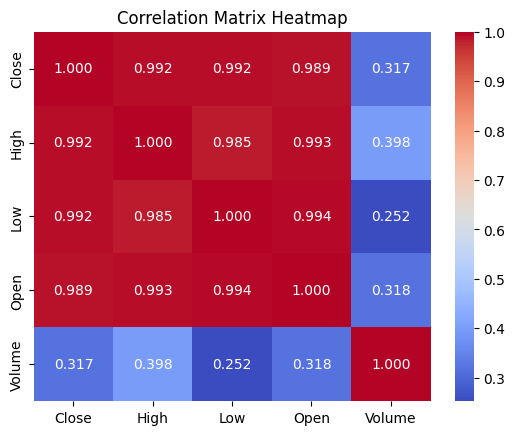

In [250]:
#stock data correlations
print(f"Correlations: \n{stock_data.corr()}")

print(f"\nHeatmap: \n")
sns.heatmap(stock_data.corr(), annot=True, fmt='.3f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [251]:
#calculate the means by the months
open_mean = stock_data.groupby(pd.Grouper(freq='ME'))['Open'].mean()
close_mean = stock_data.groupby(pd.Grouper(freq='ME'))['Close'].mean()
volume_mean = stock_data.groupby(pd.Grouper(freq='ME'))['Volume'].mean()

In [252]:
#Price increase/decrease every day
diff = close_mean - open_mean

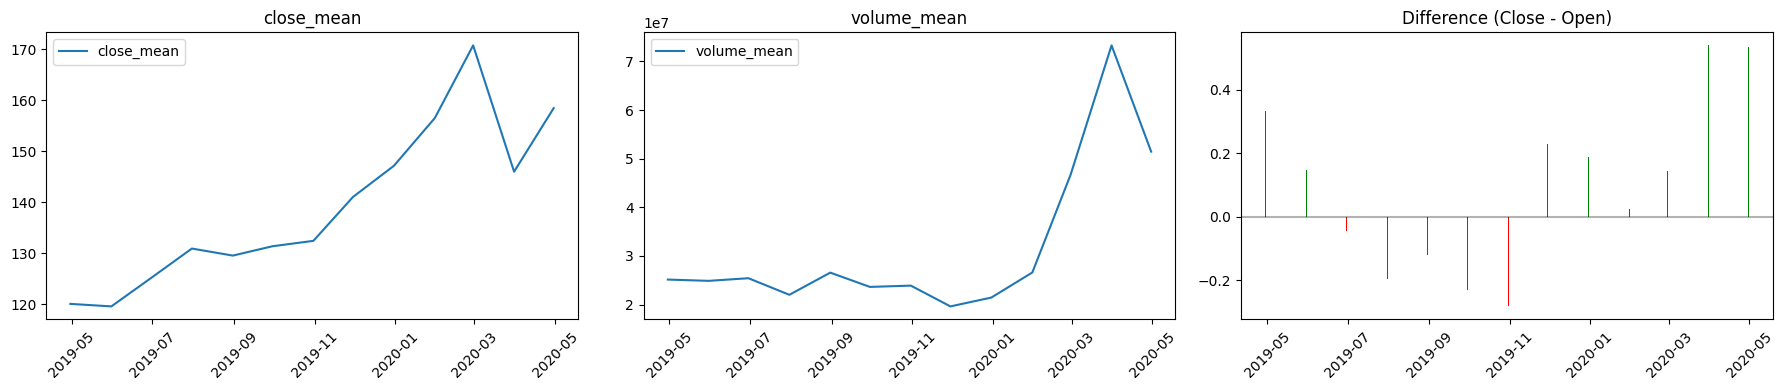

In [253]:
# Creating 3 graphs of close mean prices, volume mean values and differences of mean close and open prices in one row
figure, axis = plt.subplots(1, 3, figsize=(18, 4))

# Close mean prices
axis[0].plot(close_mean, label='close_mean')
axis[0].set_title('close_mean')

# Volume mean values
axis[1].plot(volume_mean, label='volume_mean')
axis[1].set_title('volume_mean')

# Bars representing price changes (red -> price dropped, green -> price rose)
colors = ['green' if x >= 0 else 'red' for x in diff.values]
axis[2].bar(diff.index, diff.values, color=colors)
axis[2].set_title('Difference (Close - Open)')
axis[2].axhline(y=0, color='black', linestyle='-', alpha=0.3) # Baseline

# Rotate the x ticks of each graphs
for ax in axis:
    ax.tick_params(axis='x', rotation=45)

# Display the graphs properly
plt.tight_layout()
axis[0].legend()
axis[1].legend()
plt.show()

In [254]:
# Add a target column
# Difference of close prices per day
stock_data['Change'] = stock_data['Close'] - stock_data['Close'].shift(1)

In [255]:
# Creating the target column representing classification of price actions
# Price rose -> 1
# Price dropped -> -1
# Unchanged price -> 0

stock_data['Target'] = 0  # Default - Unchanged price
stock_data.loc[stock_data['Change'] > 0, 'Target'] = 1  # Rise
stock_data.loc[stock_data['Change'] < 0, 'Target'] = -1  # Drop
stock_data.head()

,Close,High,Low,Open,Volume,Change,Target
Date,,,,,,,
2019-04-18,116.545158,116.686855,114.589671,115.430436,27991000,NaN,0
2019-04-22,116.913589,117.140311,115.789418,115.836655,15648700,0.368431,1
2019-04-23,118.500656,118.632911,116.979721,117.234781,24025500,1.587067,1
2019-04-24,118.094452,118.887980,117.631554,118.831301,31257000,-0.406204,-1
2019-04-25,122.005432,124.102623,121.703142,122.865095,38033900,3.910980,1


In [256]:
# Drop first row because there isn't previous day to get change value
stock_data = stock_data.iloc[1:]

In [257]:
###################################
# Classical Classification Models #
###################################

# Select features, target and split the data for training and testing
features = ['Open', 'Close', 'Low', 'High', 'Volume']
target = 'Target'

X = stock_data[features]
y = stock_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the features values improving the model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [258]:
# Logistic Regression
# C - Controls regularization
# Smaller C - increases regularization, reduces overfitting and makes the model simpler
# Larger C - weaker regularization, but allow to fit the model more closely, which can improve accuracy but may lead to overfitting
lr_model = LogisticRegression(C=100, random_state=42)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"Test Accuracy Score: {lr_accuracy}\n")

# Check overfitting
lr_y_train_pred = lr_model.predict(X_train)
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)
print(f"Train Accuracy Score: {lr_train_accuracy}")

Test Accuracy Score: 0.8627450980392157

Train Accuracy Score: 0.82


In [259]:
# Random Forest Classifier
# n_estimators - the number of trees that will be created to 'vote' and classify
# max_depth - limit the depth of each tree to reduce overfitting
rfc_model = RandomForestClassifier(n_estimators=90, max_depth=5, random_state=42)
rfc_model.fit(X_train, y_train)
rfc_y_pred = rfc_model.predict(X_test)
rfc_accuracy = accuracy_score(y_test, rfc_y_pred)
print(f"Test Accuracy Score: {rfc_accuracy}\n")

# Check overfitting
rfc_y_train_pred = rfc_model.predict(X_train)
rfc_train_accuracy = accuracy_score(y_train, rfc_y_train_pred)
print(f"Train Accuracy Score: {rfc_train_accuracy}")

Test Accuracy Score: 0.5294117647058824

Train Accuracy Score: 0.87


In [260]:
# Compare the models

# Logistic Regression Resutls
# Calculate the correct percentage of classification for each class
# average='weighted' - Returns the average of them
lr_f1 = f1_score(y_test, lr_y_pred, average='weighted')

# Random Forest Results
rfc_f1 = f1_score(y_test, rfc_y_pred, average='weighted')

In [261]:
# Print results
print("Model Performance Comparison \n")
print(f"Logistic Regression:")
print(f"- Accuracy: {lr_accuracy:.4f}")
print(f"- F1 Score: {lr_f1:.4f}")
print()
print(f"Random Forest:")
print(f"- Accuracy: {rfc_accuracy:.4f}")
print(f"- F1 Score: {rfc_f1:.4f}")

Model Performance Comparison 

Logistic Regression:
- Accuracy: 0.8627
- F1 Score: 0.8611

Random Forest:
- Accuracy: 0.5294
- F1 Score: 0.3865


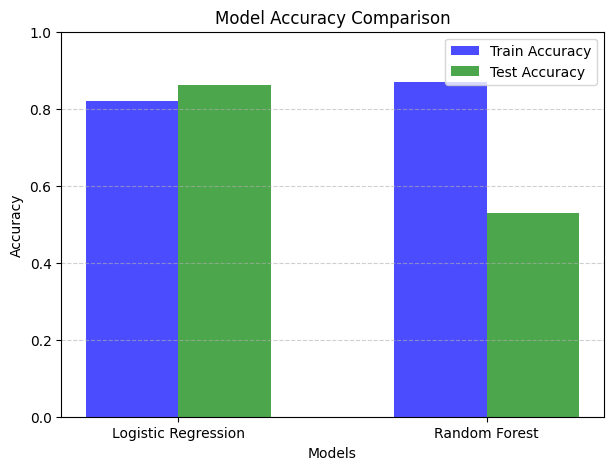

In [262]:
models = ['Logistic Regression', 'Random Forest']
accuracy_values = [lr_accuracy, rfc_accuracy]
train_accuracy_values = [lr_train_accuracy, rfc_train_accuracy]

# Set width of bars
bar_width = 0.3

# X locations for the groups
x = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(7, 5))
plt.bar(x - bar_width/2, train_accuracy_values, width=bar_width, color='blue', alpha=0.7, label="Train Accuracy")
plt.bar(x + bar_width/2, accuracy_values, width=bar_width, color='green', alpha=0.7, label="Test Accuracy")

# Formatting
plt.xticks(x, models)  # Set x-axis labels
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [263]:
########
# LSTM #
########

# Setting window size
window_size = 5

# Select features, target and split the data for training and testing
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

X_data = stock_data[features]
y_close = stock_data[target].values

# Scaling the features values improving the model
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_close.reshape(-1, 1)).flatten()

# Creating the windows
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - window_size):
    X_sequences.append(X_scaled[i:i+window_size])
    y_sequences.append(y_scaled[i+window_size])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data to training and testing
split = int(len(X_sequences) * 0.8)
X_train = X_sequences[:split]
X_test = X_sequences[split:]
y_train = y_sequences[:split]
y_test = y_sequences[split:]

# Creating and compile the LSTM model
model = Sequential([
    LSTM(100, input_shape=(window_size, len(features)), return_sequences=True),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.7653 - val_loss: 2.5519
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6932 - val_loss: 2.4154
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6439 - val_loss: 2.2862
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5784 - val_loss: 2.1617
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5454 - val_loss: 2.0347
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4828 - val_loss: 1.9184
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4670 - val_loss: 1.8030
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3570 - val_loss: 1.6822
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3381 - val_loss: 1.5718
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2846 - val_loss: 1.4705
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2572 - val_loss: 1.3736
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2253 - val_loss: 1.2827
E

In [264]:
# Create predictions
y_pred_scaled = model.predict(X_test, verbose=0).flatten()
y_pred_train_scaled = model.predict(X_train, verbose=0).flatten()

# Convert predictions back to their original form
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

LSTM model's results:
RMSE: $8.24
MAE: $7.06
LSTM model's accuracy: 95.45%
LSTM accuracy - test: 95.45%
LSTM accuracy - train: 98.51%


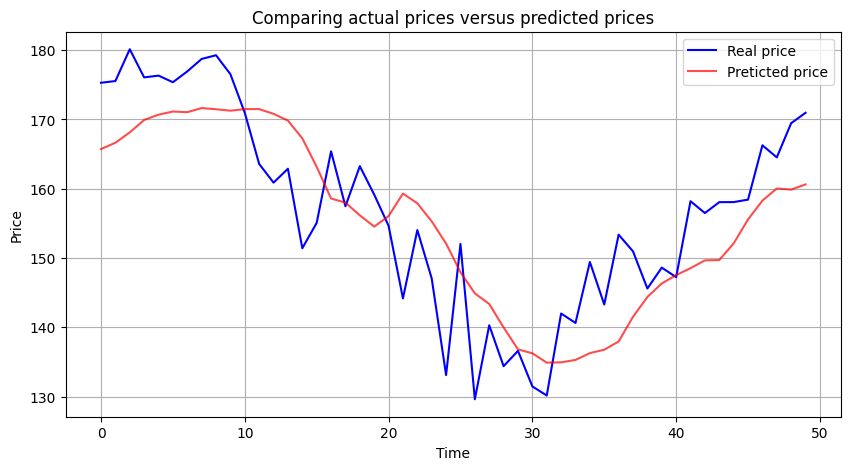

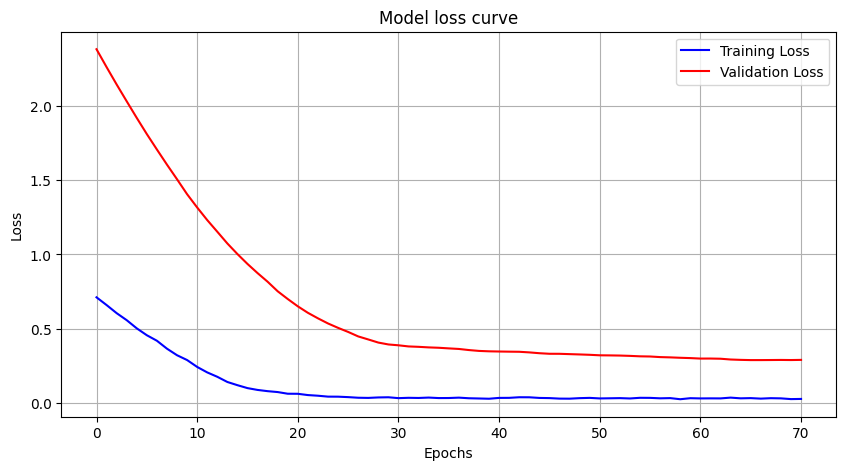

In [316]:
# Calculate model accuracy
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)

mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
train_mape = np.mean(np.abs((y_train_original - y_pred_train_original) / y_train_original)) * 100

# accuracy = 100% - error percentage
accuracy = 100 - mape
lstm_train_accuracy = 100 - train_mape

# Display the accuracy
print(f"LSTM model's results:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"LSTM model's accuracy: {accuracy:.2f}%")

# Check overfitting
print(f"LSTM accuracy - test: {accuracy:.2f}%")
print(f"LSTM accuracy - train: {lstm_train_accuracy:.2f}%")

# Graph - Comparison between real and predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label='Real price', color='blue')
plt.plot(y_pred_original, label='Preticted price', color='red', alpha=0.7)
plt.title('Comparing actual prices versus predicted prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print()

# Graph - Comparison of validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss curve')
plt.legend()
plt.grid()
plt.show()

In [266]:
#comparing between the models
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
lstm_accuracy = 100 - mape  # accuracy = 100% - error percentage

# Comparing the models' accuracy
print("\n===== Model Performance Comparison =====")
print(f"Logistic Regression accuracy: {lr_accuracy*100:.2f}%")
print(f"Random Forest accuracy: {rfc_accuracy*100:.2f}%")
print(f"LSTM model accuracy: {lstm_accuracy:.2f}%")

print("\nConclusions:")
print("• All models are shown in accuracy percentages for fair comparison")
print("• LSTM model is good at predicting exact values, while classical models are good at predicting trends")
print("• Using multiple models together can give a more complete picture")


===== Model Performance Comparison =====
Logistic Regression accuracy: 86.27%
Random Forest accuracy: 52.94%
LSTM model accuracy: 95.14%

Conclusions:
• All models are shown in accuracy percentages for fair comparison
• LSTM model is good at predicting exact values, while classical models are good at predicting trends
• Using multiple models together can give a more complete picture


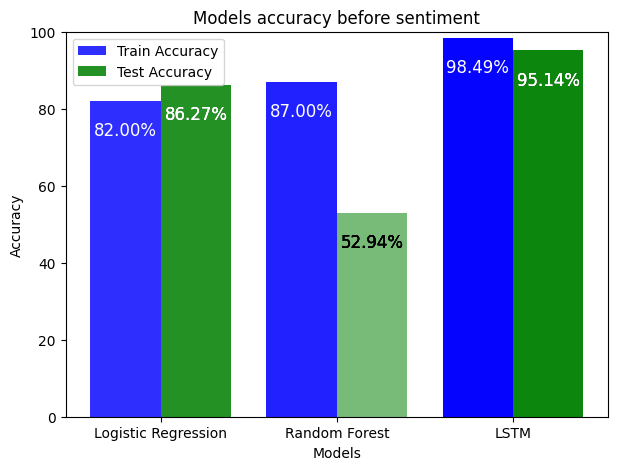

In [267]:
# Compare models before sentiment
models = ["Logistic Regression", "Random Forest", "LSTM"]
models_accuracy = [lr_accuracy * 100, rfc_accuracy * 100, lstm_accuracy]
models_train_accuracy = [lr_train_accuracy * 100, rfc_train_accuracy * 100, lstm_train_accuracy]

compare_models(models, models_accuracy, models_train_accuracy, "Models accuracy before sentiment")

In [268]:
############
# News EDA #
############

In [269]:
# CNBC news EDA
cnbc_news_df = pd.read_csv('/content/cnbc_headlines.csv')

In [270]:
cnbc_news_df.info()
cnbc_news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


In [271]:
# 280 lines that all the columns' values ara NaN
(cnbc_news_df.isna().sum(axis=1) == len(cnbc_news_df.columns)).sum()

np.int64(280)

In [272]:
# Delete NaN rows
cnbc_news_df = cnbc_news_df.dropna().reset_index(drop=True)

In [273]:
# Converting Time column to datetime data type
cnbc_news_df['Time'] = pd.to_datetime(cnbc_news_df['Time'])

<ipython-input-273-8e7446f05c2b>:2: FutureWarning: Parsed string " 7:51  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  cnbc_news_df['Time'] = pd.to_datetime(cnbc_news_df['Time'])
<ipython-input-273-8e7446f05c2b>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cnbc_news_df['Time'] = pd.to_datetime(cnbc_news_df['Time'])
<ipython-input-273-8e7446f05c2b>:2: FutureWarning: Parsed string " 7:33  PM ET Fri, 17 July 2020" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.


In [274]:
cnbc_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Headlines    2800 non-null   object        
 1   Time         2800 non-null   datetime64[ns]
 2   Description  2800 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 65.8+ KB


In [275]:
# Guardian news EDA
guardian_news_df = pd.read_csv('/content/guardian_headlines.csv')

In [276]:
guardian_news_df.info()
guardian_news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17800 non-null  object
 1   Headlines  17800 non-null  object
dtypes: object(2)
memory usage: 278.3+ KB


,Time,Headlines
0,18-Jul-20,Johnson is asking Santa for a Christmas recovery
1,18-Jul-20,‘I now fear the worst’: four grim tales of wor...
2,18-Jul-20,Five key areas Sunak must tackle to serve up e...
3,18-Jul-20,Covid-19 leaves firms ‘fatally ill-prepared’ f...
4,18-Jul-20,The Week in Patriarchy \n\n\n Bacardi's 'lad...


In [277]:
# Converting Time column to datetime data type
guardian_news_df['Time'] = pd.to_datetime(guardian_news_df['Time'], errors='coerce')

<ipython-input-277-6dd536c82204>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  guardian_news_df['Time'] = pd.to_datetime(guardian_news_df['Time'], errors='coerce')


In [278]:
guardian_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       17760 non-null  datetime64[ns]
 1   Headlines  17800 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 278.3+ KB


In [279]:
# Dropping NaN Time created due to coerce option
guardian_news_df = guardian_news_df.dropna().reset_index(drop=True)
guardian_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17760 entries, 0 to 17759
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       17760 non-null  datetime64[ns]
 1   Headlines  17760 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 277.6+ KB


In [280]:
# Reuters news EDA
reuters_news_df = pd.read_csv('/content/reuters_headlines.csv')

In [281]:
reuters_news_df.info()
reuters_news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...


In [282]:
# Converting Time column to datetime data type
reuters_news_df['Time'] = pd.to_datetime(reuters_news_df['Time'])
reuters_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Headlines    32770 non-null  object        
 1   Time         32770 non-null  datetime64[ns]
 2   Description  32770 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 768.2+ KB


In [283]:
# Combining all Headlines
news_df = pd.concat([cnbc_news_df[['Time', 'Headlines']], guardian_news_df[['Time', 'Headlines']], reuters_news_df[['Time', 'Headlines']]], ignore_index=True)
news_df.info()
news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53330 entries, 0 to 53329
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       53330 non-null  datetime64[ns]
 1   Headlines  53330 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 833.4+ KB


,Time,Headlines
0,2020-07-17 19:51:00,Jim Cramer: A better way to invest in the Covi...
1,2020-07-17 19:33:00,Cramer's lightning round: I would own Teradyne
2,2020-07-17 19:25:00,"Cramer's week ahead: Big week for earnings, ev..."
3,2020-07-17 16:24:00,IQ Capital CEO Keith Bliss says tech and healt...
4,2020-07-16 19:36:00,Wall Street delivered the 'kind of pullback I'...


In [284]:
# Clean headlines from stopwords (contain only meaningful words)

# Download stopwords list
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Cleaning the headlines
def clean_headlines(headline):
  headline = headline.lower()
  headline = re.sub(r"[^a-z0-9\s]", "", headline)
  words = word_tokenize(headline)
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return " ".join(words)

news_df['clean_headlines'] = news_df['Headlines'].apply(clean_headlines)

news_df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Time,Headlines,clean_headlines
0,2020-07-17 19:51:00,Jim Cramer: A better way to invest in the Covi...,jim cramer better way invest covid19 vaccine g...
1,2020-07-17 19:33:00,Cramer's lightning round: I would own Teradyne,cramers lightning round would teradyne
2,2020-07-17 19:25:00,"Cramer's week ahead: Big week for earnings, ev...",cramers week ahead big week earnings even bigg...
3,2020-07-17 16:24:00,IQ Capital CEO Keith Bliss says tech and healt...,iq capital ceo keith bliss say tech healthcare...
4,2020-07-16 19:36:00,Wall Street delivered the 'kind of pullback I'...,wall street delivered kind pullback ive waitin...


In [285]:
# Create Tokenizer and fit it to the headlines
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(news_df['clean_headlines'])

In [286]:
# Display the 10 most popular words
word_counts = tokenizer.word_counts
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\nTop 10 most common words:\n")
print("word: # of occurrences\n")
for i, (word, occurrences) in enumerate(top_words[:10]):
  print(f"{i+1}) {word}: {occurrences}")


Top 10 most common words:

word: # of occurrences

1) u: 7491
2) say: 4577
3) china: 3316
4) uk: 3110
5) trade: 2872
6) new: 2391
7) deal: 2280
8) business: 2190
9) coronavirus: 2113
10) ceo: 2069


In [287]:
# Convert the headlines to sequences
sequences = tokenizer.texts_to_sequences(news_df['clean_headlines'])

In [288]:
# Getting max length sequence
maxlen = max(len(seq) for seq in sequences)

# Padding the sequences to be same length for the model
padded_sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [289]:
# LSTM model for headline sentiment

X = np.array(padded_sequences)

# Create the model
sentiment_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32),
    LSTM(64),
    Dense(32, activation ='relu'),
    Dense(1, activation='sigmoid')
])

# Unsupervised predictions
sentiment_preds = sentiment_model.predict(padded_sequences)

1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


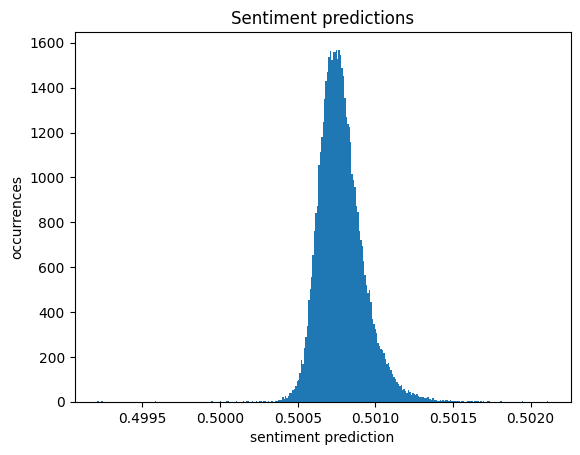

In [290]:
plt.hist(sentiment_preds, bins="auto")
plt.title("Sentiment predictions")
plt.xlabel("sentiment prediction")
plt.ylabel("occurrences")
plt.show()

In [291]:
news_df['sentiment'] = sentiment_preds

In [292]:
news_df.info()
news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53330 entries, 0 to 53329
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             53330 non-null  datetime64[ns]
 1   Headlines        53330 non-null  object        
 2   clean_headlines  53330 non-null  object        
 3   sentiment        53330 non-null  float32       
dtypes: datetime64[ns](1), float32(1), object(2)
memory usage: 1.4+ MB


,Time,Headlines,clean_headlines,sentiment
0,2020-07-17 19:51:00,Jim Cramer: A better way to invest in the Covi...,jim cramer better way invest covid19 vaccine g...,0.500679
1,2020-07-17 19:33:00,Cramer's lightning round: I would own Teradyne,cramers lightning round would teradyne,0.500624
2,2020-07-17 19:25:00,"Cramer's week ahead: Big week for earnings, ev...",cramers week ahead big week earnings even bigg...,0.500781
3,2020-07-17 16:24:00,IQ Capital CEO Keith Bliss says tech and healt...,iq capital ceo keith bliss say tech healthcare...,0.500846
4,2020-07-16 19:36:00,Wall Street delivered the 'kind of pullback I'...,wall street delivered kind pullback ive waitin...,0.500661


In [293]:
# Getting only the relevant daily average sentiments based on trading days
news_df['Time'] = pd.to_datetime(news_df['Time'])
time_mask = pd.to_datetime(stock_data.index)
relevant_news = news_df[news_df['Time'].isin(time_mask)]
daily_sentiment = relevant_news.groupby('Time')['sentiment'].mean()

In [294]:
# Adding the sentiment values to each trading day(row)
stock_data['sentiment'] = daily_sentiment
stock_data.info()
stock_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2019-04-22 to 2020-04-17
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      251 non-null    float64
 1   High       251 non-null    float64
 2   Low        251 non-null    float64
 3   Open       251 non-null    float64
 4   Volume     251 non-null    int64  
 5   Change     251 non-null    float64
 6   Target     251 non-null    int64  
 7   sentiment  251 non-null    float32
dtypes: float32(1), float64(5), int64(2)
memory usage: 16.7 KB


,Close,High,Low,Open,Volume,Change,Target,sentiment
Date,,,,,,,,
2019-04-22,116.913589,117.140311,115.789418,115.836655,15648700,0.368431,1,0.500796
2019-04-23,118.500656,118.632911,116.979721,117.234781,24025500,1.587067,1,0.500804
2019-04-24,118.094452,118.887980,117.631554,118.831301,31257000,-0.406204,-1,0.500803
2019-04-25,122.005432,124.102623,121.703142,122.865095,38033900,3.910980,1,0.500787
2019-04-26,122.704491,123.299644,121.882624,122.524999,23654900,0.699059,1,0.500785


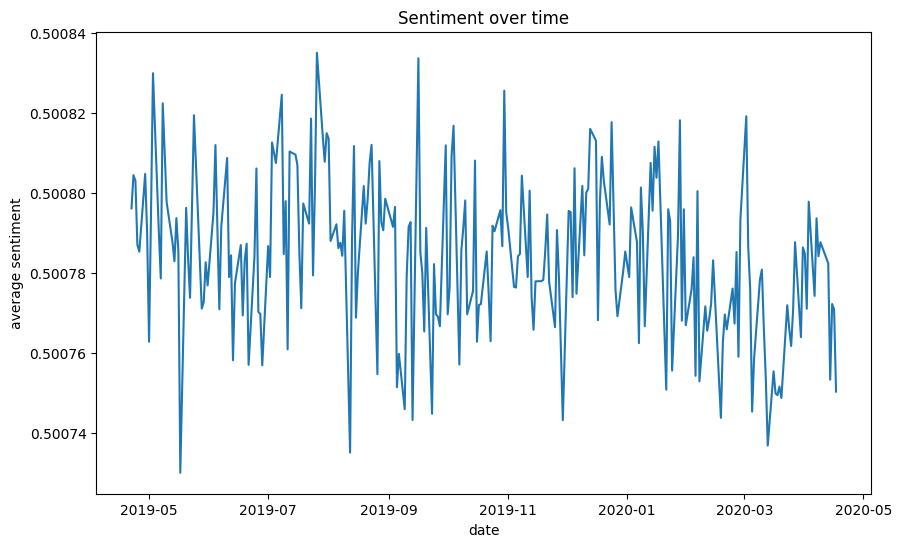

In [295]:
plt.figure(figsize=(10,6))
plt.plot(stock_data['sentiment'])
plt.title('Sentiment over time')
plt.xlabel("date")
plt.ylabel("average sentiment")
plt.show()

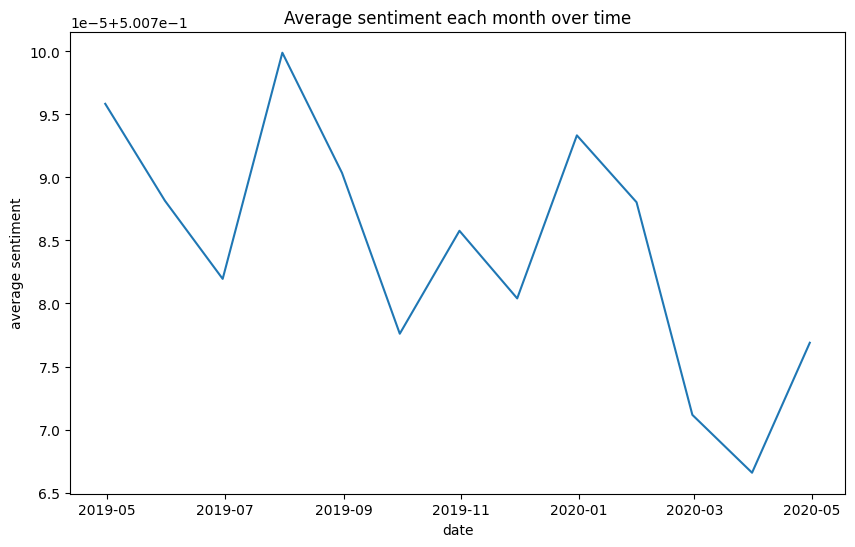

In [296]:
# Calculate and display a plot of monthly sentiment mean
sentiment_mean = stock_data.groupby(pd.Grouper(freq='ME'))['sentiment'].mean()

plt.figure(figsize=(10, 6))
plt.plot(sentiment_mean)
plt.title('Average sentiment each month over time')
plt.xlabel("date")
plt.ylabel("average sentiment")
plt.show()

In [297]:
# Classical models with sentiment

# Select features, target and split the data for training and testing
features = ['Open', 'Close', 'Low', 'High', 'Volume', 'sentiment']
target = 'Target'

X = stock_data[features]
y = stock_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the features values improving the model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [298]:
# Logistic Regression
# C - Controls regularization
# Smaller C - increases regularization, reduces overfitting and makes the model simpler
# Larger C - weaker regularization, but allow to fit the model more closely, which can improve accuracy but may lead to overfitting
lr_model = LogisticRegression(C=100, random_state=42)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_sent_accuracy = accuracy_score(y_test, lr_y_pred)
print(f"Test Accuracy Score: {lr_sent_accuracy}\n")

# Check overfitting
lr_y_train_pred = lr_model.predict(X_train)
lr_train_sent_accuracy = accuracy_score(y_train, lr_y_train_pred)
print(f"Train Accuracy Score: {lr_train_accuracy}")

Test Accuracy Score: 0.8627450980392157

Train Accuracy Score: 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [299]:
# Random Forest Classifier
# n_estimators - the number of trees that will be created to 'vote' and classify
# max_depth - limit the depth of each tree to reduce overfitting
rfc_model = RandomForestClassifier(n_estimators=90, max_depth=5, random_state=42)
rfc_model.fit(X_train, y_train)
rfc_y_pred = rfc_model.predict(X_test)
rfc_sent_accuracy = accuracy_score(y_test, rfc_y_pred)
print(f"Test Accuracy Score: {rfc_sent_accuracy}\n")

# Check overfitting
rfc_y_train_pred = rfc_model.predict(X_train)
rfc_train_sent_accuracy = accuracy_score(y_train, rfc_y_train_pred)
print(f"Train Accuracy Score: {rfc_train_accuracy}")

Test Accuracy Score: 0.5490196078431373

Train Accuracy Score: 0.87


In [300]:
# LSTM with sentiment

# Setting window size
window_size = 5

# Select features, target and split the data for training and testing
features = ['Open', 'High', 'Low', 'Volume', 'sentiment']
target = 'Close'

X_data = stock_data[features]
y_close = stock_data[target].values

# Scaling the features values improving the model
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_close.reshape(-1, 1)).flatten()

# Creating the windows
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - window_size):
    X_sequences.append(X_scaled[i:i+window_size])
    y_sequences.append(y_scaled[i+window_size])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split data to training and testing
split = int(len(X_sequences) * 0.8)
X_train = X_sequences[:split]
X_test = X_sequences[split:]
y_train = y_sequences[:split]
y_test = y_sequences[split:]

# Creating and compile the LSTM model
model = Sequential([
    LSTM(100, input_shape=(window_size, len(features)), return_sequences=True),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.7032 - val_loss: 2.3788
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6675 - val_loss: 2.2588
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5979 - val_loss: 2.1420
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5801 - val_loss: 2.0290
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5543 - val_loss: 1.9173
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4501 - val_loss: 1.8087
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4359 - val_loss: 1.7052
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3761 - val_loss: 1.6035
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3332 - val_loss: 1.5052
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2858 - val_loss: 1.4049
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2246 - val_loss: 1.3156
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2210 - val_lo

In [301]:
# Create predictions
y_pred_scaled = model.predict(X_test, verbose=0).flatten()
y_pred_train_scaled = model.predict(X_train, verbose=0).flatten()

# Convert predictions back to their original form
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

LSTM model's results:
RMSE: $8.24
MAE: $7.06
LSTM model's accuracy: 95.45%

Overfitting check:
LSTM accuracy - test: 95.45%
LSTM accuracy - train: 98.51%


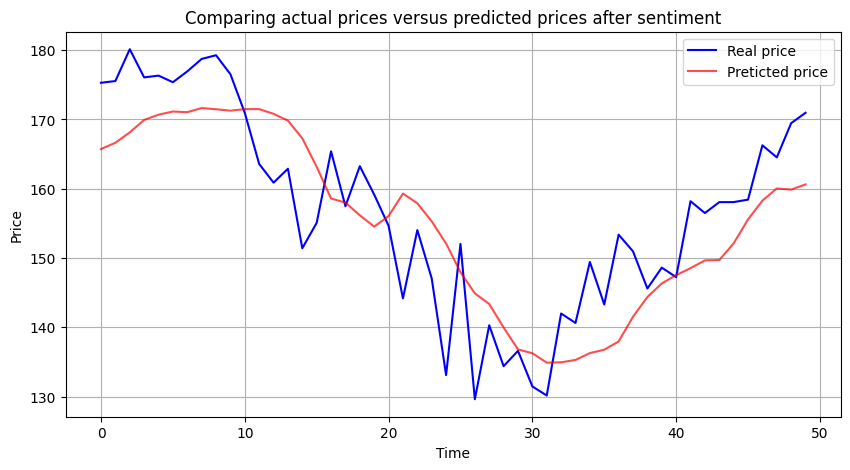

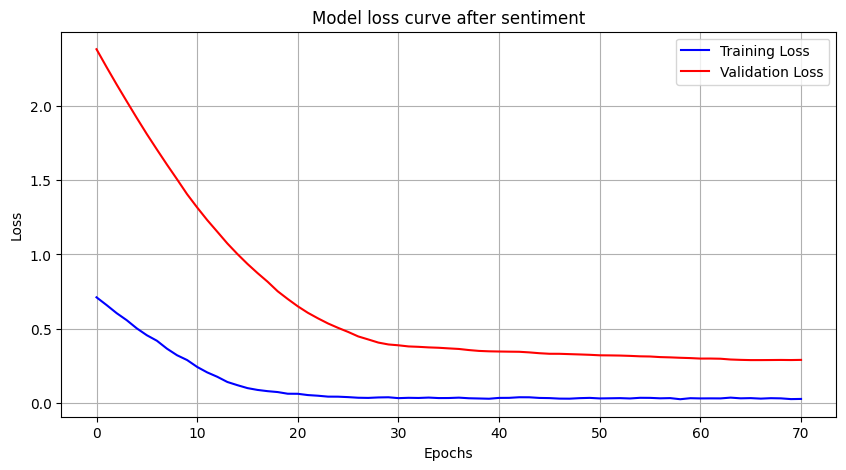

In [315]:
# Calculate model accuracy
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)

mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
train_mape = np.mean(np.abs((y_train_original - y_pred_train_original) / y_train_original)) * 100


# accuracy = 100% - error percentage
lstm_sent_accuracy = 100 - mape
lstm_sent_train_accuracy = 100 - train_mape

# Display the accuracy
print(f"LSTM model's results:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"LSTM model's accuracy: {lstm_sent_accuracy:.2f}%")

# Check overfitting
print("\nOverfitting check:")
print(f"LSTM accuracy - test: {lstm_sent_accuracy:.2f}%")
print(f"LSTM accuracy - train: {lstm_sent_train_accuracy:.2f}%")

# Graph - Comparison between real and predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_original, label='Real price', color='blue')
plt.plot(y_pred_original, label='Preticted price', color='red', alpha=0.7)
plt.title('Comparing actual prices versus predicted prices after sentiment')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print()

# Graph - Comparison of validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss curve after sentiment')
plt.legend()
plt.grid()
plt.show()

In [303]:
#comparing between the models

# Comparing the models' accuracy
print("===== Model Performance Comparison =====")
print(f"Logistic Regression accuracy: {lr_sent_accuracy*100:.2f}%")
print(f"Random Forest accuracy: {rfc_sent_accuracy*100:.2f}%")
print(f"LSTM model accuracy: {lstm_sent_accuracy:.2f}%")

print("\nConclusions:")
print("• The sentiment seems to decrease the accuracy by a little")
print("• The sentiment wasn't that helpful probably because of the unsupervised learning technique")
print("• LSTM model is good at predicting exact values, while classical models are good at predicting trends")

===== Model Performance Comparison =====
Logistic Regression accuracy: 86.27%
Random Forest accuracy: 54.90%
LSTM model accuracy: 95.45%

Conclusions:
• The sentiment seems to decrease the accuracy by a little
• The sentiment wasn't that helpful probably because of the unsupervised learning technique
• LSTM model is good at predicting exact values, while classical models are good at predicting trends


In [312]:
# Display bar comparison of models' accuracy
def compare_models(models, models_accuracy, models_train_accuracy, title):
  # Set width of bars
  bar_width = 0.4

  # X locations for the groups
  x = np.arange(len(models))

  # Create bar chart
  plt.figure(figsize=(7, 5))
  train_accuracy_bars = plt.bar(x - bar_width/2, models_train_accuracy, width=bar_width, color='blue', label="Train Accuracy")
  test_accuracy_bars = plt.bar(x + bar_width/2, models_accuracy, width=bar_width, color='green', label="Test Accuracy")

  for i, bar in enumerate(train_accuracy_bars):
    alpha = models_train_accuracy[i] / 100
    bar.set_alpha(alpha)
    if alpha > 0.8:
      plt.text(i - bar_width/2, models_train_accuracy[i]-10, f"{models_train_accuracy[i]:.2f}%", ha='center', va='bottom', fontsize=12, color="white")
    else:
      plt.text(i - bar_width/2, models_train_accuracy[i]-10, f"{models_train_accuracy[i]:.2f}%", ha='center', va='bottom', fontsize=12)

  for i, bar in enumerate(test_accuracy_bars):
    alpha = models_accuracy[i] / 100
    bar.set_alpha(alpha)
    if alpha > 0.8:
      plt.text(i + bar_width/2, models_accuracy[i]-10, f"{models_accuracy[i]:.2f}%", ha='center', va='bottom', fontsize=12, color="white")
    else:
      plt.text(i + bar_width/2, models_accuracy[i]-10, f"{models_accuracy[i]:.2f}%", ha='center', va='bottom', fontsize=12)


  # Formatting
  plt.xticks(x, models)  # Set x-axis labels
  plt.ylim(0, 100)  # Accuracy is between 0 and 1
  plt.title(title)
  plt.xlabel('Models')
  plt.ylabel('Accuracy')
  plt.legend()

  # Show the plot
  plt.show()

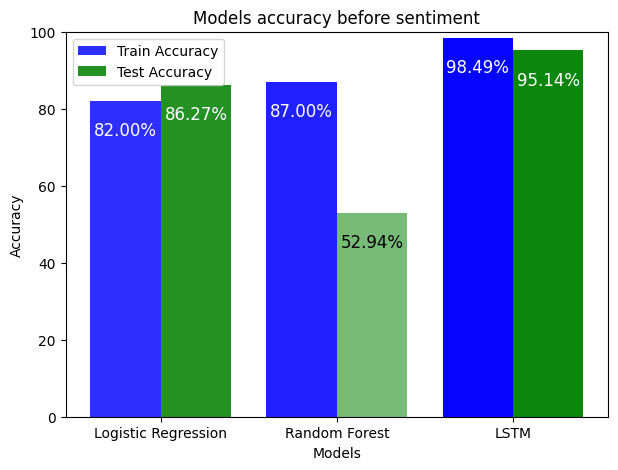

In [313]:
# Compare models before sentiment
models = ["Logistic Regression", "Random Forest", "LSTM"]
models_accuracy = [lr_accuracy * 100, rfc_accuracy * 100, lstm_accuracy]
models_train_accuracy = [lr_train_accuracy * 100, rfc_train_accuracy * 100, lstm_train_accuracy]

compare_models(models, models_accuracy, models_train_accuracy, "Models accuracy before sentiment")

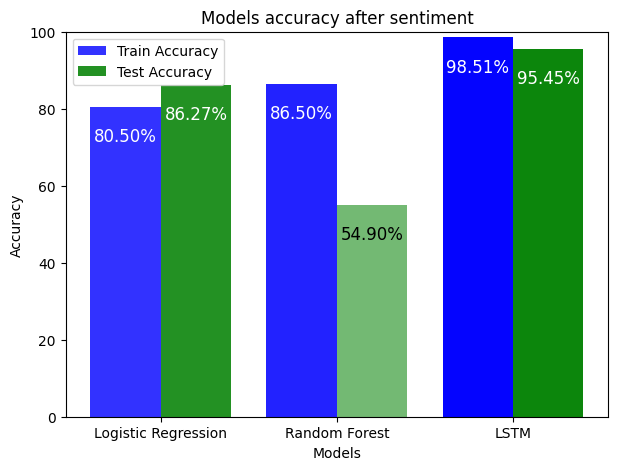

In [314]:
# Compare models after sentiment
models = ["Logistic Regression", "Random Forest", "LSTM"]
models_accuracy = [lr_sent_accuracy * 100, rfc_sent_accuracy * 100, lstm_sent_accuracy]
models_train_accuracy = [lr_train_sent_accuracy * 100, rfc_train_sent_accuracy * 100, lstm_sent_train_accuracy]

compare_models(models, models_accuracy, models_train_accuracy, "Models accuracy after sentiment")